## MarcusGPT? 
Rethink name later.
Essentially gives you quotes from Meditations to go about your day, depending upon relevance of the text you provide. 

## Part 1. Cleaning meditations.txt

In [1]:
import os
import pandas as pd
import torch
import subprocess

In [2]:
# download from https://www.gutenberg.org/files/2680/old/medma10.txt
# !wget https://www.gutenberg.org/files/2680/old/medma10.txt
meditations_path = 'copymedma10.txt'

def get_clean_quotes(meditations_path):
    with open(meditations_path,'rb') as f:
        text = f.read()
    not_clean = text.decode()
    replaced_r = not_clean.replace('\r',' ')
    delimiters = replaced_r.replace('\n \n','____')
    removed_breaks = delimiters.replace('\n',' ')
    singular_quotes_unclean = removed_breaks.split('____')
    clean_quotes = [quote for quote in singular_quotes_unclean if not len(quote.split()) <= 3]
    return clean_quotes

In [3]:
clean_quotes = get_clean_quotes(meditations_path)

In [4]:
import re
def split_text(text, max_words_per_part=300):
    """
    Split a text block into parts with a maximum number of words per part.

    Args:
        text (str): The text block to be split.
        max_words_per_part (int): Maximum number of words per part. Default is 10.

    Returns:
        list: List of parts, where each part contains a maximum of `max_words_per_part` words.
    """

    # Split the text into sentences
    sentences = re.split(r'(?<=[.!?])\s+', text)

    parts = []
    current_part = ""
    word_count = 0

    for sentence in sentences:
        words = sentence.split()
        if word_count + len(words) <= max_words_per_part:
            current_part += sentence + " "
            word_count += len(words)
        else:
            parts.append(current_part.strip())
            current_part = sentence + " "
            word_count = len(words)

    if current_part:
        parts.append(current_part.strip())

    return parts

In [5]:
new_quotes = []
for quote in clean_quotes:
    if len(quote.split()) > 300:
        parts = split_text(quote,300)
        new_quotes.extend(parts)
    else:
        new_quotes.append(quote)

In [102]:
import pickle
with open('quotes.pkl', 'wb') as f:
    pickle.dump(new_quotes, f)


## Getting emotions for each quotes in Meditations
I don't expect this to work that well considering the lingo is slightly challenging. 

In [21]:
from transformers import BertTokenizer
import torch.nn as nn
from transformers import BertPreTrainedModel, BertModel


class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
        self.loss_fct = nn.BCEWithLogitsLoss()

        self.init_weights()

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )
        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            loss = self.loss_fct(logits, labels)
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

class Emotions:
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")
        self.model = BertForMultiLabelClassification.from_pretrained("monologg/bert-base-cased-goemotions-original")
        
    def get_emotions(self,text):
        inputs = self.tokenizer(text,return_tensors="pt")
        
        if inputs['input_ids'].shape[1] > 512:
            return {"labels":'None',"scores":None}
        
        outputs = self.model(**inputs)
        scores =  1 / (1 + torch.exp(-outputs[0]))  # Sigmoid

        for item in scores:
            labels = []
            scores1 = []
            for idx, s in enumerate(item):

                labels.append(self.model.config.id2label[idx])
                scores1.append(s.data.numpy().item())

        result = {"labels": labels, "scores": scores1}
        return dict(zip(result['labels'], result['scores']))

emo = Emotions()
emotion_dicts = []
for quote in new_quotes:
    emotion_dicts.append(emo.get_emotions(quote))

In [22]:
emo = Emotions()

Get all emotions for all quotes, we can find the maximum/thresholds later

In [8]:
emotion_dicts = []
for quote in new_quotes:
    emotion_dicts.append(emo.get_emotions(quote))

In [9]:
df = pd.DataFrame.from_dict(emotion_dicts)
df['quote'] = new_quotes
emotion_order = ['quote','admiration', 'amusement', 'anger', 'annoyance', 
                 'approval', 'caring', 'confusion', 'curiosity', 
                 'desire', 'disappointment', 'disapproval', 'disgust',
                 'embarrassment', 'excitement', 'fear', 'gratitude', 
                 'grief', 'joy', 'love', 'nervousness', 'optimism', 
                 'pride', 'realization', 'relief', 'remorse', 'sadness', 
                 'surprise', 'neutral']
df = df[emotion_order]

In [10]:
# save as csv
df.to_csv('meditation_quotes_emotions.csv')

In [11]:
import numpy as np

# Define the order of emotions
emotion_order = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

# Convert the emotion dictionaries to numpy arrays
emotion_vectors = np.array([[emotion_dict.get(emotion, 0) for emotion in emotion_order] for emotion_dict in emotion_dicts])


In [7]:
## alternative way to get vectors
df = pd.read_csv('meditation_quotes_emotions.csv')

In [14]:
import numpy as np

emotion_order = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 
                 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 
                 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 
                 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 
                 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
emotion_vectors = np.array(df[emotion_order])

In [13]:
emotion_vectors[:2]

array([[4.23682444e-02, 4.91897634e-04, 8.47503170e-03, 1.94874145e-02,
        1.32112682e-03, 8.21851310e-04, 2.34877691e-04, 5.99501014e-04,
        1.24931068e-03, 3.41272680e-03, 5.34896215e-04, 3.95466154e-03,
        3.84093821e-03, 3.44672590e-04, 9.59957310e-04, 1.84171557e-04,
        3.80790094e-04, 2.98995117e-04, 5.80410298e-04, 3.93910392e-04,
        9.20360500e-04, 3.09852278e-03, 5.03993034e-03, 2.07472200e-04,
        1.15483324e-03, 4.13608941e-04, 2.06121549e-04, 9.89274800e-01],
       [9.91137233e-03, 1.56421884e-04, 6.97013340e-04, 5.69874479e-04,
        4.08340624e-04, 2.53453909e-04, 1.01437769e-03, 2.01363768e-03,
        5.32634556e-04, 4.40739008e-04, 1.41852128e-03, 2.01964343e-04,
        5.16709697e-04, 1.31002534e-03, 2.75344471e-04, 7.74767160e-01,
        1.85012686e-04, 4.00104822e-04, 9.41459963e-04, 1.11785608e-04,
        3.72769136e-04, 1.21641753e-03, 3.18586174e-03, 1.15635456e-03,
        8.46632232e-04, 1.84084638e-04, 7.93566927e-04, 8.69646

In [15]:
emotion_vectors[:2]

array([[4.23682444e-02, 4.91897634e-04, 8.47503170e-03, 1.94874145e-02,
        1.32112682e-03, 8.21851310e-04, 2.34877691e-04, 5.99501014e-04,
        1.24931068e-03, 3.41272680e-03, 5.34896215e-04, 3.95466154e-03,
        3.84093821e-03, 3.44672590e-04, 9.59957310e-04, 1.84171557e-04,
        3.80790094e-04, 2.98995117e-04, 5.80410298e-04, 3.93910392e-04,
        9.20360500e-04, 3.09852278e-03, 5.03993034e-03, 2.07472200e-04,
        1.15483324e-03, 4.13608941e-04, 2.06121549e-04, 9.89274800e-01],
       [9.91137233e-03, 1.56421884e-04, 6.97013340e-04, 5.69874479e-04,
        4.08340624e-04, 2.53453909e-04, 1.01437769e-03, 2.01363768e-03,
        5.32634556e-04, 4.40739008e-04, 1.41852128e-03, 2.01964343e-04,
        5.16709697e-04, 1.31002534e-03, 2.75344471e-04, 7.74767160e-01,
        1.85012686e-04, 4.00104822e-04, 9.41459963e-04, 1.11785608e-04,
        3.72769136e-04, 1.21641753e-03, 3.18586174e-03, 1.15635456e-03,
        8.46632232e-04, 1.84084638e-04, 7.93566927e-04, 8.69646

In [16]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Faiss

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [83]:
# def plot_emotion_importance(emotions):
#     # Sort dictionary by value for better visualization
# #     sorted_emotions = dict(sorted(emotions.items(), key=lambda item: item[1]))
#     sorted_emotions = emotions
#     # Create figure and axes
#     plt.figure(figsize=(5,10))
#     sns.barplot(x=list(sorted_emotions.values()), y=list(sorted_emotions.keys()), palette="viridis")

#     # Set plot title and labels
#     plt.title('Importance of Emotions')
#     plt.xlabel('Importance')
#     plt.ylabel('Emotion')

#     # Show the plot
#     plt.show()
def array_to_dict(keys, values):
    return dict(zip(keys, values))


def plot_emotion_importance(emotions1, emotions2):
    # Sort dictionaries by value for better visualization
    # sorted_emotions1 = dict(sorted(emotions1.items(), key=lambda item: item[1]))
    # sorted_emotions2 = dict(sorted(emotions2.items(), key=lambda item: item[1]))

    sorted_emotions1 = emotions1
    sorted_emotions2 = array_to_dict(emotion_order, emotions2)
    fig, ax = plt.subplots(1, 2, figsize=(20,10))

    # Plot the first dictionary
    sns.barplot(x=list(sorted_emotions1.values()), y=list(sorted_emotions1.keys()), palette="viridis", ax=ax[0])
    ax[0].set_title('Importance of Emotions - query')
    ax[0].set_xlabel('Importance')
    ax[0].set_ylabel('Emotion')

    # Plot the second dictionary
    sns.barplot(x=list(sorted_emotions2.values()), y=list(sorted_emotions2.keys()), palette="viridis", ax=ax[1])
    ax[1].set_title('Importance of Emotions - quote')
    ax[1].set_xlabel('Importance')
    ax[1].set_ylabel('Emotion')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [84]:
import faiss

index = faiss.IndexFlatL2(emotion_vectors.shape[1])
index.add(emotion_vectors)


In [87]:
def get_relevant_quotes(user_text, num_quotes=5):
    # Get emotions from user text
    emotion_dict = emo.get_emotions(user_text)

    # Convert emotion dict to vector
    emotion_vector = np.array([emotion_dict.get(emotion, 0) for emotion in emotion_order])

    # Search for closest quotes in the index
    D, I = index.search(np.array([emotion_vector]), num_quotes)

    print(f'User Text:\n{user_text}')
    for i in I[0]:
        print(f'Quote:\n{new_quotes[i]}')
        plot_emotion_importance(emotion_dict,emotion_vectors[i])
    
    # Return the closest quotes
#     return [new_quotes[i] for i in I[0]]

## Saving the index

In [101]:
faiss.write_index(index,'data/emotion_vectors.index')

## Testing functionality

User Text:
I am so in love today. I have fallen in love with someone
Quote:
XXII.  The earth, saith the poet, doth often long after the rain.  So is the glorious sky often as desirous to fall upon the earth,  which argues a mutual kind of love between them.  And so (say I)  doth the world bear a certain affection of love to whatsoever shall come  to pass With thine affections shall mine concur, O world.  The same  (and no other) shall the object of my longing be which is of thine.  Now that the world doth love it is true indeed so is it as commonly said,  and acknowledged ledged, when, according to the Greek phrase,  imitated by the Latins, of things that used to be, we say commonly,  that they love to be. 


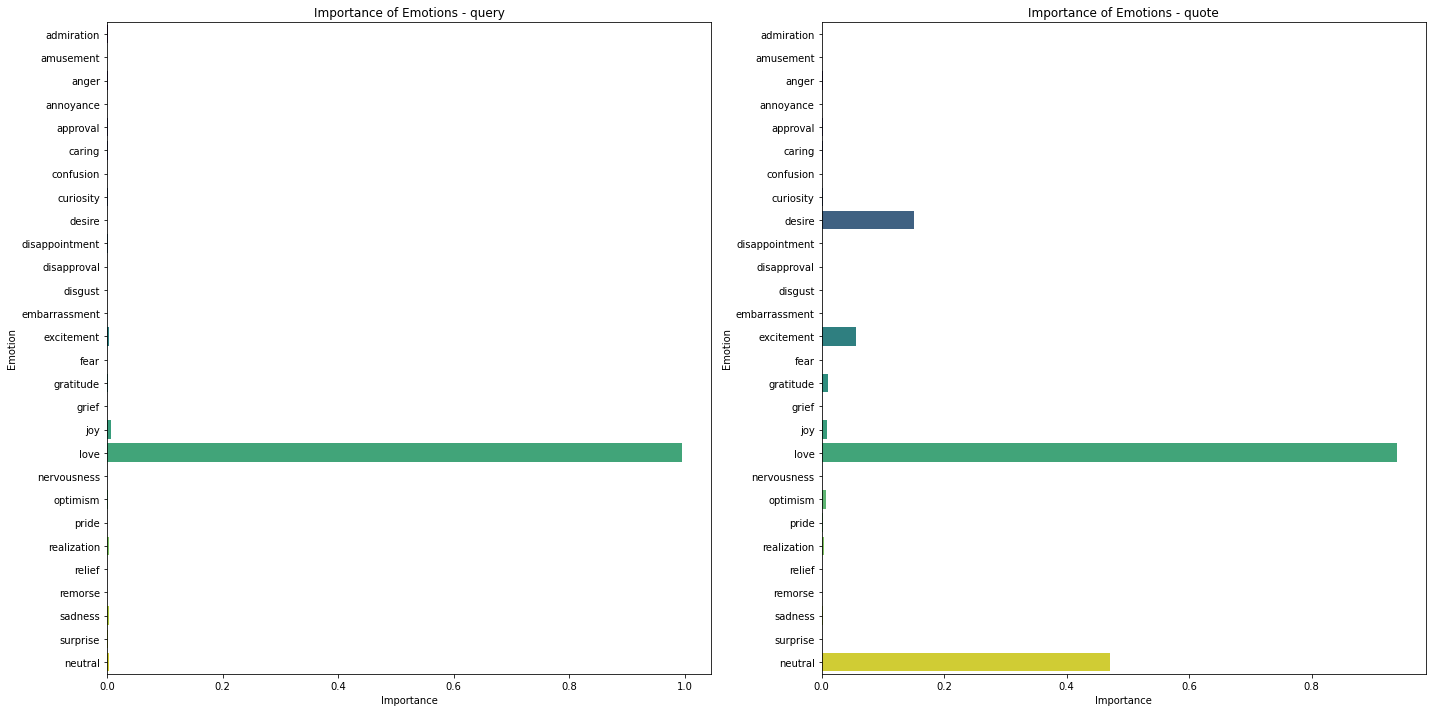

Quote:
XXXV.  Fit and accommodate thyself to that estate and to those occurrences,  which by the destinies have been annexed unto thee; and love  those men whom thy fate it is to live with; but love them truly.  An instrument, a tool, an utensil, whatsoever it be, if it be fit  for the purpose it was made for, it is as it should be though  he perchance that made and fitted it, be out of sight and gone.  But in things natural, that power which hath framed and fitted them,  is and abideth within them still:  for which reason she ought  also the more to be respected, and we are the more obliged (if we  may live and pass our time according to her purpose and intention)  to think that all is well with us, and according to our own minds.  After this manner also, and in this respect it is, that he that is  all in all doth enjoy his happiness. 


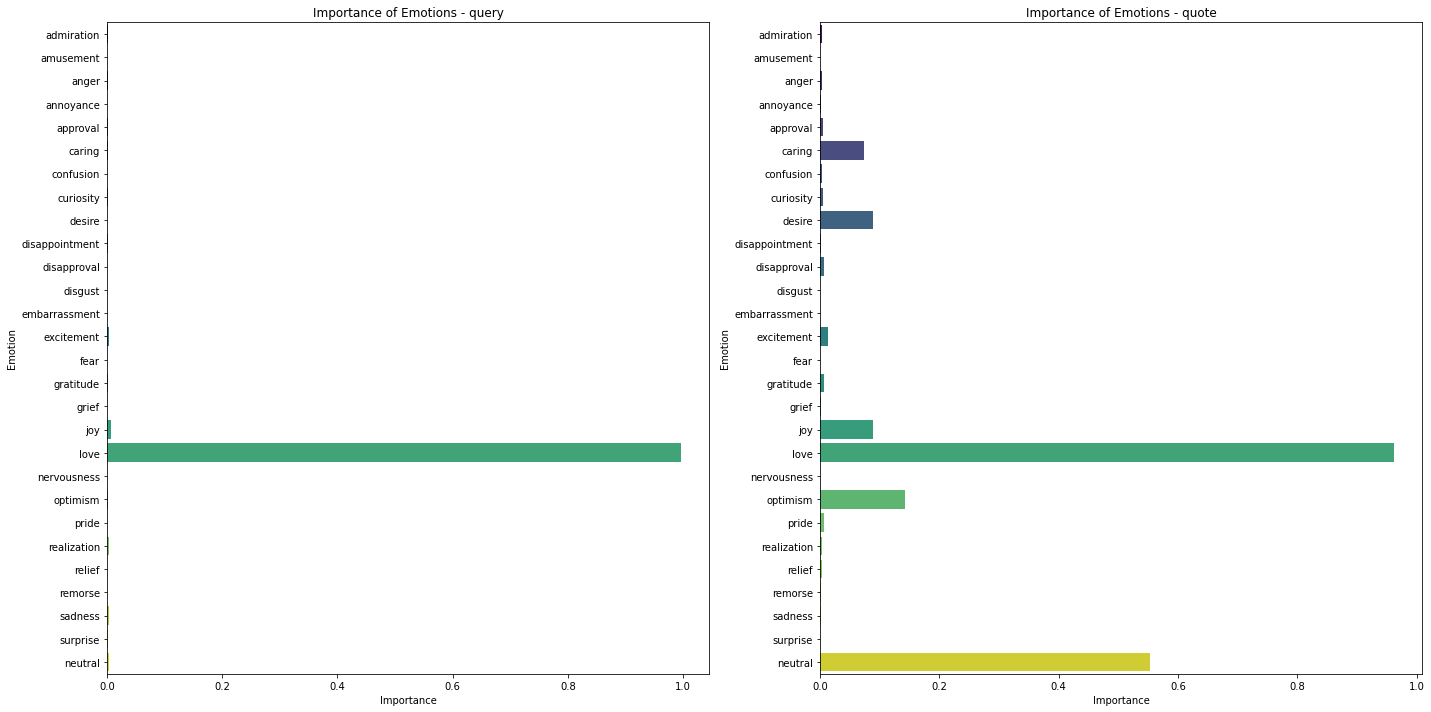

Quote:
XI.  From my brother Severus, to be kind and loving to all them  of my house and family; by whom also I came to the knowledge  of Thrasea and Helvidius, and Cato, and Dio, and Brutus.  He it was also that did put me in the first conceit and desire  of an equal commonwealth, administered by justice and equality;  and of a kingdom wherein should be regarded nothing more  than the good and welfare of the subjects.  Of him also,  to observe a constant tenor, (not interrupted, with any other  cares and distractions,) in the study and esteem of philosophy:  to be bountiful and liberal in the largest measure; always to  hope the best; and to be confident that my friends love me.  In whom I moreover observed open dealing towards those whom  he reproved at any time, and that his friends might without  all doubt or much observation know what he would, or would not,  so open and plain was he. 


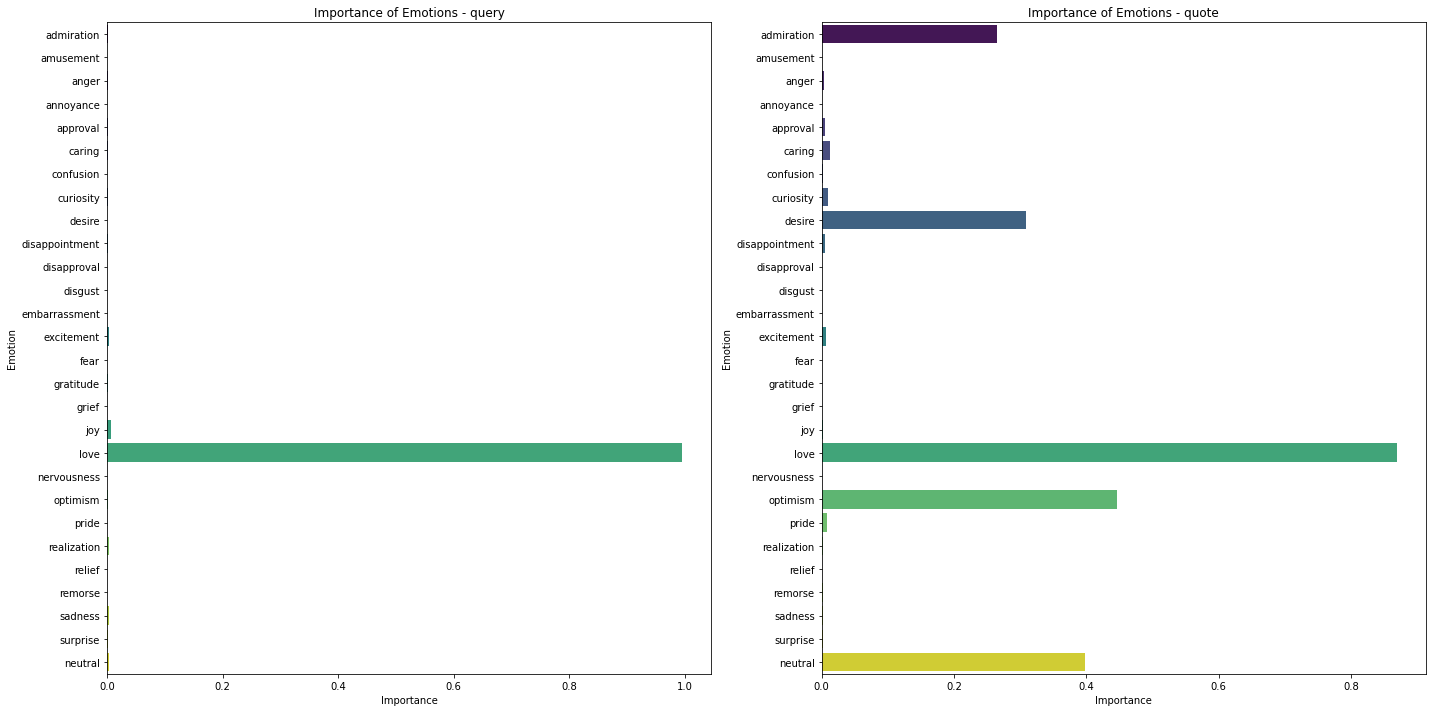

Quote:
I. O my soul, the time I trust will be, when thou shalt be good,  simple, single, more open and visible, than that body by which it  is enclosed.  Thou wilt one day be sensible of their happincss,  whose end is love, and their affections dead to all worldly things.  Thou shalt one day be full, and in want of no external thing:  not seeking pleasure from anything, either living or insensible,  that this world can afford; neither wanting time for the continuation  of thy pleasure, nor place and opportunity, nor the favour either  of the weather or of men.  When thou shalt have content in thy  present estate, and all things present shall add to thy content:  when thou shalt persuade thyself, that thou hast all things;  all for thy good, and all by the providence of the Gods:  and of things future also shalt be as confident, that all will do well,  as tending to the maintenance and preservation in some sort, of his  perfect welfare and happiness, who is perfection of life, of goodne

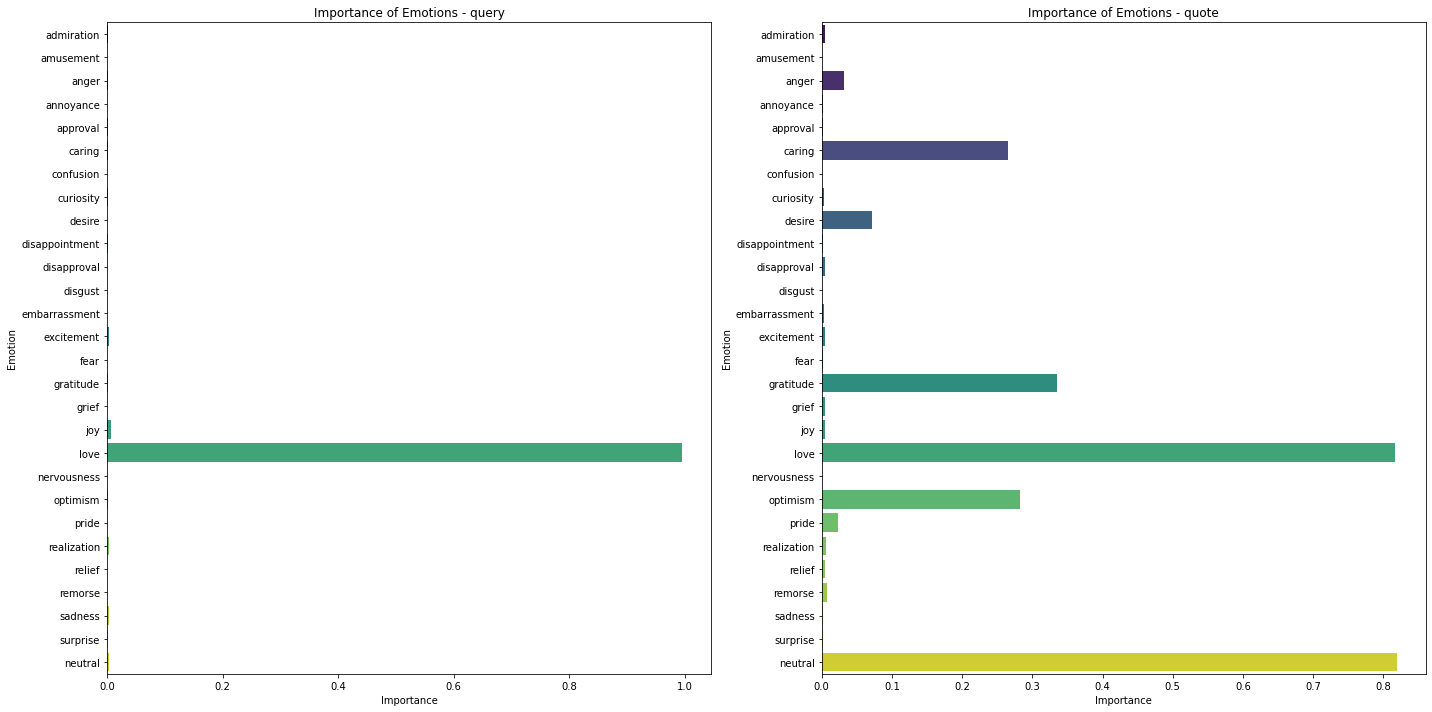

Quote:
XLII.  Let the several deaths of men of all sorts, and of all  sorts of professions, and of all sort of nations, be a perpetual  object of thy thoughts, . . . so that thou mayst even come down  to Philistio, Phoebus, and Origanion.  Pass now to other generations.  Thither shall we after many changes, where so many brave orators are;  where so many grave philosophers; Heraclitus, Pythagoras, Socrates.  Where so many heroes of the old times; and then so many brave  captains of the latter times; and so many kings.  After all these,  where Eudoxus, Hipparchus, Archimedes; where so many other sharp,  generous, industrious, subtile, peremptory dispositions;  and among others, even they, that have been the greatest scoffers  and deriders of the frailty and brevity of this our human life;  as Menippus, and others, as many as there have been such as he.  Of all these consider, that they long since are all dead, and gone.  And what do they suffer by it!  Nay they that have not so much  as

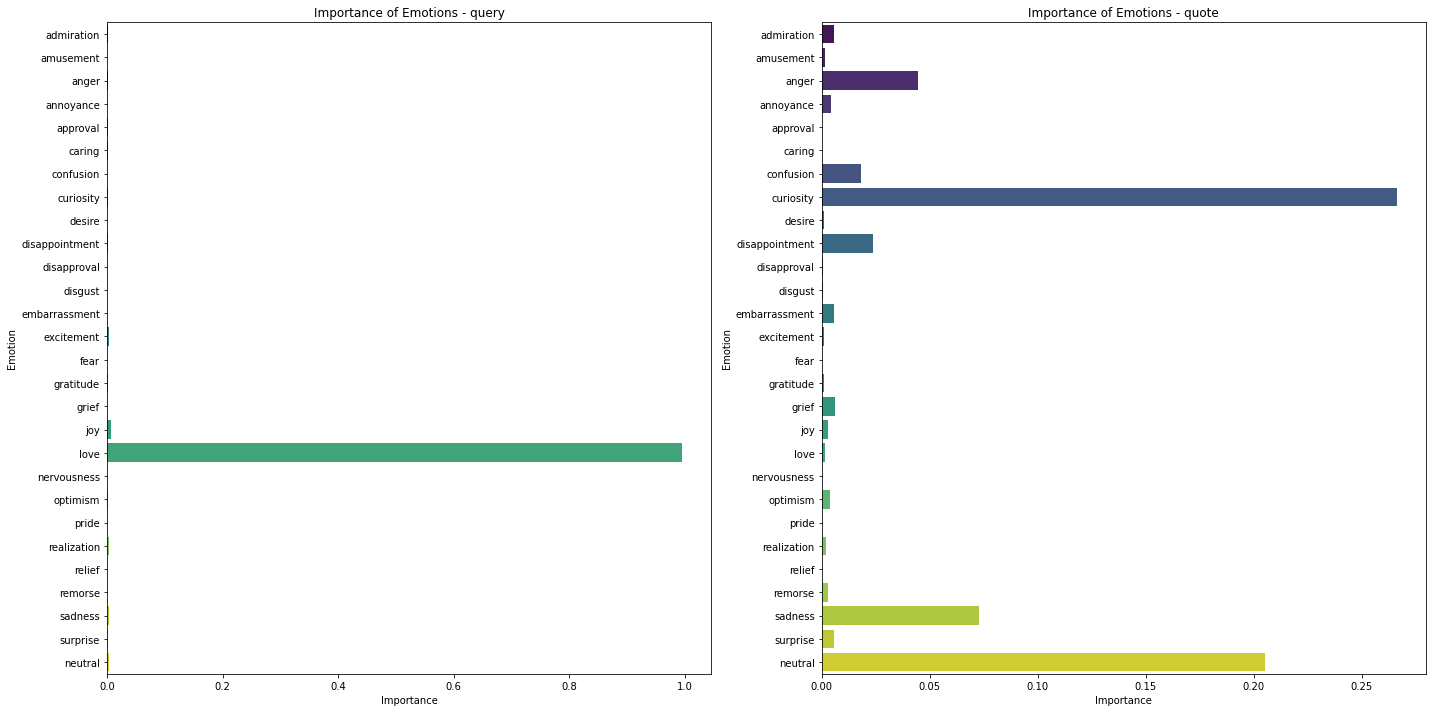

In [103]:

# Get the relevant quotes for a user's text
# user_text = """I have been going through the motions today. I feel dejected because my family is going through a hard time, and I have no motivation."""

# user_text = """I feel like I have lost faith in myself and I am not at my best.
#                I feel like I have let myself down and I'm unable to focus on relevant things.
#                How do I even get over this feeling of worthlessness?"""

# user_text = """I am so happy today. SO fUCKING happy because today is my birthday and I am feeling
#                good about myself. One more year to go!"""


# user_text = """This is pointless. Why am I working so hard? Nothing ever seems to go my way.
#                Why can't things be easier for me?
# #             """

# user_text = """L. Will either passengers, or patients, find fault and complain,  either the one if they be well carried, or the others if well cured?  Do they take care for any more than this; the one, that their shipmaster  may bring them safe to land, and the other, that their physician  may effect their recovery? 
# """

# user_text = """Do you ever feel like there are no goals left to achieve? I think I have done everything
#                that I had to do in life and now I'm waiting for nirvana. In a sea of never ending 
#                possibilities. Such an amazing content life.
#             """

user_text = """I am so in love today. I have fallen in love with someone"""


relevant_quotes = get_relevant_quotes(user_text)

# for quote in relevant_quotes:
#     print('*'*10)
#     print(quote)



In [ ]:
# after you're doing running the notebook, set this to false
os.environ['KMP_DUPLICATE_LIB_OK']='False'

In [89]:
import statistics

def calculate_statistics(numbers):
    mean = sum(numbers) / len(numbers)
    median = statistics.median(numbers)
    mode = statistics.mode(numbers)
    average = statistics.mean(numbers)
    maximum = max(numbers)
    minimum = min(numbers)
    
    return {
        "mean": mean,
        "median": median,
        "mode": mode,
        "average": average,
        "maximum": maximum,
        "minimum": minimum
    }import faiss

index = faiss.IndexFlatL2(emotion_vectors.shape[1])
index.add(emotion_vectors)


In [90]:
calculate_statistics(true_len)

{'mean': 648.6,
 'median': 582,
 'mode': 914,
 'average': 648.6,
 'maximum': 1093,
 'minimum': 392}

In [91]:
calculate_statistics(false_len)

{'mean': 136.53987730061348,
 'median': 116.5,
 'mode': 118,
 'average': 136.53987730061348,
 'maximum': 405,
 'minimum': 8}

In [94]:
for quote in clean_quotes[10:20]:
    length = len(quote.split())
    print(length)
    if length > 380:
        quote[:]

914
780
411
200
118
146
172
228
325
88


## Semantic Search for Quotes

In [ ]:
## Semantic Search for Quotes

from sentence_transformers import SentenceTransformer
import numpy as np
import faiss

class QuoteSearch:
    def __init__(self, quotes):
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.quotes = quotes
        self.embeddings = self.model.encode(quotes)
        self.index = faiss.IndexFlatL2(self.embeddings.shape[1])
        self.index.add(self.embeddings)

    def search(self, query, k=5):
        query_embedding = self.model.encode([query])
        distances, indices = self.index.search(query_embedding, k)
        results = [self.quotes[i] for i in indices[0]]
        return results

from transformers import pipeline

class SentimentAnalysis:
    def __init__(self):
        self.analyzer = pipeline('sentiment-analysis')

    def analyze(self, text):
        result = self.analyzer(text)[0]
        return result['label'], result['score']

# from .sentiment_analysis import SentimentAnalysis
# from .quote_search import QuoteSearch

class Recommender:
    def __init__(self, quotes):
        self.sentiment_analysis = SentimentAnalysis()
        self.quote_search = QuoteSearch(quotes)

    def recommend(self, user_input):
        sentiment, _ = self.sentiment_analysis.analyze(user_input)
        recommended_quotes = self.quote_search.search(sentiment)
        return recommended_quotes

recommender = Recommender(clean_quotes[:10])
user_input = """to observe carefully the several  dispositions of my friends, not to be offended with idiots,  nor unseasonably to set upon those that are carried with the  vulgar opinions, with the theorems, and tenets of philosophers:  his conversation being an example how a man might accommodate  himself to all men and companies; so that though his company were  sweeter and more pleasing than any flatterer's cogging and fawning;  yet was it at the same time most respected and reverenced:  who also had a proper happiness and faculty, rationally and  methodically to find out, and set in order all necessary  determinations and instructions for a man's life.  A man without  ever the least appearance of anger, or any other passion;  able at the same time most exactly to observe the Stoic Apathia,  or unpassionateness, and yet to be most tender-hearted: ever  of good credit; and yet almost without any noise, or rumour:  very learned, and yet making little show."""
recommender.recommend(user_input)